# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [86]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


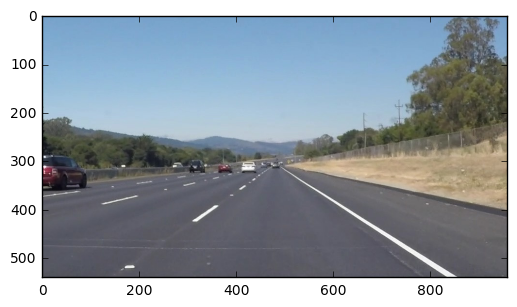

In [87]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [88]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [89]:
def hough_lines_to_full_extent(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines_to_full_extent(line_img, lines)
    return line_img

def draw_lines_to_full_extent(img, lines, color=[255, 0, 0], thickness=8):
    lines = lines.reshape(lines.shape[0], lines.shape[2])
    slopes = (lines[:, 3] - lines[:, 1]) / (lines[:, 2] - lines[:, 0])
    lines = lines[~np.isnan(slopes) & ~np.isinf(slopes)]
    slope = slopes[~np.isnan(slopes) & ~np.isinf(slopes)]

    y_max = img.shape[0]
    y_min = lines.reshape([lines.shape[0] * 2, lines.shape[1] // 2])[:, 1].min()
    right_threshold = 0
    right_slope = slope[slope < right_threshold]
    # print('any right_slope is nan: ', np.any(~np.isnan(right_slope)))
    right_lines = lines[slope < right_threshold]

    left_threshold = 0
    left_slope = slope[slope > left_threshold]
    # print('left_slope value: ', left_slope)
    # print('any left_slope is nan: ', np.any(~np.isnan(left_slope)))
    left_lines = lines[slope > left_threshold]
    
    
    if len(right_slope) > 0:
        avg_right_slope = right_slope.mean()
        avg_right_x, avg_right_y = np.mean(right_lines.reshape(right_lines.shape[0] * 2, right_lines.shape[1] // 2), axis=0)
        right_intercept = avg_right_y - (avg_right_slope * avg_right_x)
        x_right_lowest = float(y_min - right_intercept) / avg_right_slope
        x_right_max = float(y_max - right_intercept) / avg_right_slope
        cv2.line(img, (int(x_right_max), int(y_max)), (int(x_right_lowest), int(y_min)), color, thickness)

    if len(left_slope) > 0: 
        avg_left_slope = left_slope.mean()
        avg_left_x, avg_left_y = np.mean(left_lines.reshape(left_lines.shape[0] * 2, left_lines.shape[1] // 2), axis=0)
        left_intercept = avg_left_y - (avg_left_slope * avg_left_x)
        x_left_lowest = float(y_min - left_intercept) / avg_left_slope
        x_left_max = float(y_max - left_intercept) / avg_left_slope
        cv2.line(img, (int(x_left_max), int(y_max)), (int(x_left_lowest), int(y_min)), color, thickness)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [90]:
import os
img_list = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [91]:
def detect_lane_line(image):
    gray_img = grayscale(image)
    blur_gray = gaussian_blur(gray_img, kernel_size=5)
    edges = canny(blur_gray, low_threshold=50, high_threshold=150)
    imshape = image.shape
    # vertices = np.array([[(100,imshape[0]),(480, 310), (490, 315), (900,imshape[0])]])
    vertices = np.array([[(100,imshape[0]),(480, 310), (490, 315), (900,imshape[0])]])
    marked_edges = region_of_interest(edges, vertices)
    line_img = hough_lines(marked_edges, rho=2, theta=(np.pi/180), threshold=15, min_line_len=40, max_line_gap=20)
    final_image = weighted_img(line_img, image)
    return final_image

In [92]:
def read_image(image_path):
    image = mpimg.imread(image_path).astype('uint8')
    print('This image is:', type(image), 'with dimesions:', image.shape)
    return image


def plot_and_save(image, image_name, processed_img_dir):
    plt.figure()
    plt.imshow(image)
    img_path = processed_img_dir + image_name
    clean_target_dir(processed_img_dir, image_name)
    plt.savefig(img_path)
    
    
def clean_target_dir(dir, img_name):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    img_path = dir + img_name
    if os.path.isfile(img_path):
        os.remove(img_path)
    

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


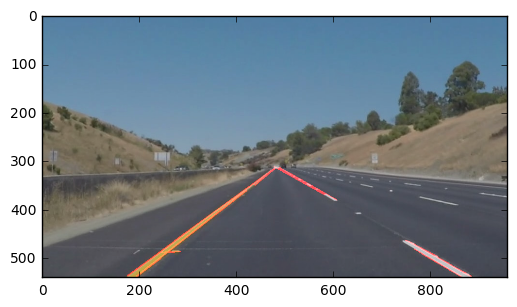

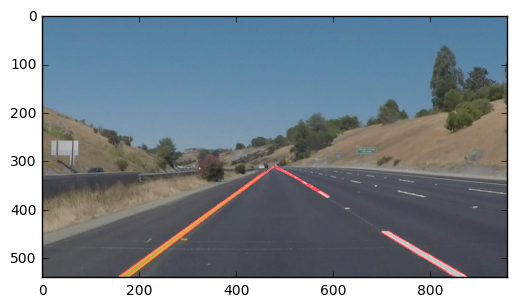

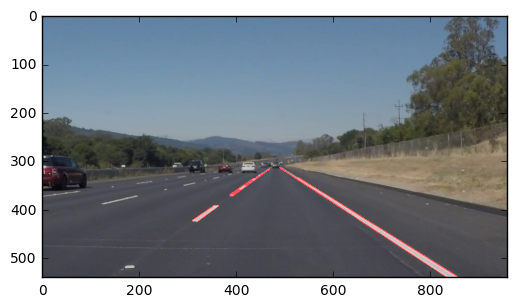

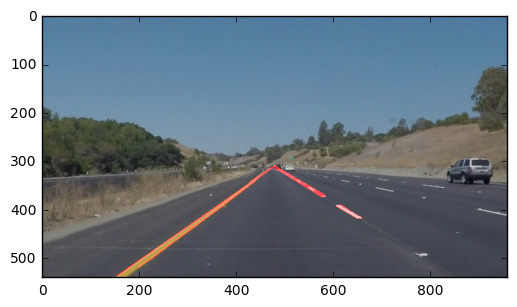

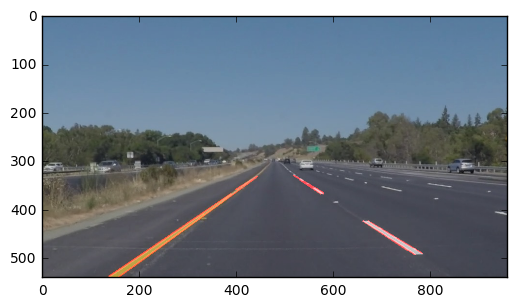

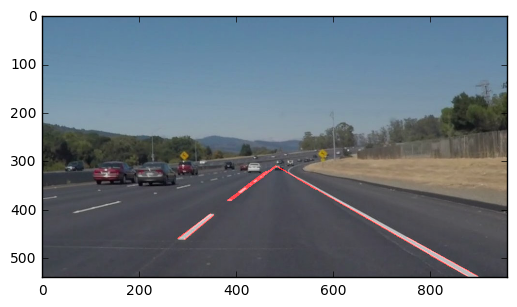

In [93]:
image_dir = 'test_images/'
processed_img_dir = image_dir + 'processed/'
for image_name in img_list:
    image_path = image_dir + image_name
    if os.path.isdir(image_path):
        continue
    image = read_image(image_path)
    processed_image = detect_lane_line(image)
    plot_and_save(processed_image, image_name, processed_img_dir)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [94]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [95]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = detect_lane_line(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [96]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4








  0%|          | 0/222 [00:00<?, ?it/s]





  2%|▏         | 4/222 [00:00<00:06, 34.87it/s]





  4%|▍         | 9/222 [00:00<00:05, 36.46it/s]





  5%|▌         | 12/222 [00:00<00:06, 33.28it/s]





  7%|▋         | 16/222 [00:00<00:06, 33.92it/s]





  9%|▉         | 20/222 [00:00<00:06, 33.17it/s]





 11%|█         | 24/222 [00:00<00:05, 33.32it/s]





 13%|█▎        | 28/222 [00:00<00:06, 32.30it/s]





 14%|█▍        | 32/222 [00:00<00:05, 34.05it/s]





 16%|█▌        | 36/222 [00:01<00:05, 32.89it/s]





 18%|█▊        | 40/222 [00:01<00:05, 32.70it/s]





 20%|█▉        | 44/222 [00:01<00:06, 29.05it/s]





 21%|██        | 47/222 [00:01<00:09, 19.43it/s]





 23%|██▎       | 50/222 [00:01<00:08, 19.89it/s]





 24%|██▍       | 53/222 [00:01<00:08, 18.98it/s]





 25%|██▌       | 56/222 [00:02<00:09, 16.94it/s]





 26%|██▌       | 58/222 [00:02<00:12, 13.10it/s]





 27%|██▋       | 60/222 [00:02<00:12, 12.65it/s]





 28%|██▊       | 62/222 [00:02<00

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 40.1 s, sys: 1.75 s, total: 41.9 s
Wall time: 17.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [97]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [98]:
def detect_lane_line_solid_line(image):
    gray_img = grayscale(image)
    blur_gray = gaussian_blur(gray_img, kernel_size=5)
    edges = canny(blur_gray, low_threshold=50, high_threshold=150)
    imshape = image.shape
    # vertices = np.array([[(100,imshape[0]),(480, 310), (490, 315), (900,imshape[0])]])
    vertices = np.array([[(0,imshape[0]),(450, 310), (490, 315), (imshape[1],imshape[0])]])
    # vertices = np.array([[(0,imshape[0]),(450, 310), (490, 315), (imshape[1],imshape[0])]])
    marked_edges = region_of_interest(edges, vertices)
    
    # change hough edge detection to full extent version
    line_img = hough_lines_to_full_extent(marked_edges, rho=2, theta=(np.pi/180), threshold=15, min_line_len=40, max_line_gap=20)
    final_image = weighted_img(line_img, image)
    return final_image

def process_image_solid_line(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = detect_lane_line_solid_line(image)
    return result

In [99]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_solid_line)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4








  0%|          | 0/682 [00:00<?, ?it/s]





  0%|          | 3/682 [00:00<00:23, 28.76it/s]





  1%|          | 6/682 [00:00<00:23, 28.42it/s]





  1%|▏         | 10/682 [00:00<00:21, 30.86it/s]





  2%|▏         | 14/682 [00:00<00:20, 32.69it/s]





  3%|▎         | 18/682 [00:00<00:20, 33.06it/s]





  3%|▎         | 22/682 [00:00<00:19, 34.23it/s]





  4%|▍         | 26/682 [00:00<00:19, 34.16it/s]





  4%|▍         | 30/682 [00:00<00:18, 34.60it/s]





  5%|▍         | 34/682 [00:00<00:18, 34.40it/s]





  6%|▌         | 38/682 [00:01<00:19, 33.61it/s]





  6%|▌         | 42/682 [00:01<00:20, 31.86it/s]





  7%|▋         | 46/682 [00:01<00:20, 30.80it/s]





  7%|▋         | 50/682 [00:01<00:24, 25.42it/s]





  8%|▊         | 53/682 [00:01<00:34, 18.42it/s]





  8%|▊         | 56/682 [00:02<00:44, 14.14it/s]





  9%|▊         | 58/682 [00:02<00:55, 11.24it/s]





  9%|▉         | 60/682 [00:02<00:51, 12.01it/s]





  9%|▉         | 62/682 [00:02<00

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min 21s, sys: 5.28 s, total: 2min 27s
Wall time: 57.5 s


In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Answer: 

Brief introduction of my current pipeline
Workflow of my working pipeline is: 

1) take a single image as input

2) convert the image to  numpy array

3) process the image to a single channel(0-255 in each cell in the 2-d numpy matrix) by do grayscale

4) do Gaussian smoothing/blurring by gaussian_blur() function in order to average pixel colors with its surroundings pixels. (For my case, I choose kernel_size = 5, for I tested on images and I think 5 gives best value)

5) Do a canny edge detection by using gradient method to find thick edges. It is used for find individual pixels (value greater than low_threshold) follow the strongest gradients(defined by high_threshold value) 

6) From the output of Canny Edge detection's output (only limited curves on it), define an interested area in the image by using region_of_interest, for the camera in a car in relatively fixed, therefore its vision range is relatively fixed, too. 

7) Use Hough Transform to represent filtered line segments as y = m*x + b in each picture frame.

8) For the solid line from Hough Transform's line segments, I seperate the lanes into left and right lane by its slope. Then get average slope and average (x,y) value from all left lane. Since the goal is to find y=m*x+b, we can use the average value of x, y, m, then we can calculate b. By using lowest y in all left lane points, we can use the same linear equation to get x_low. y_high and x_high are using the same methods. Then we can use (x_min, y_min), (x_max, y_max) to draw a new line on each picture. By the same methods, I get the right lane.

9) Aggregate image from last step with its original image and get the final image in numpy array.



Potential shortcomings (Situations this algorithm is likely to fail)

1) In this algorithm, lane line has to be a straight line. If the lane is not straight, it will fail.

2) If there are no lane lines on some part of a lane, it will fail. 

3) If the color of the lane lines are not so distinguishable, it will likely to fail.

4) If people drive downhill, its region of interest will be larger. It will probably not be accurate

5) It's front view must be broad, not vehicles etc in near front. 




Suggestions on possible improvement

1) Grid search on parameters for each function to find optimal parameters

2) For step 8, draw the solid line, I think we can use clustering and weighted average of each line segments' length to improve its accuracy. (Currently, tiny line segment has the same importance as longest line segment.)

3) Be able to draw different curves in the picture frame, not just straight line.

4) Use deep learning for accurate and dynamic parameter settings. Currently, many things are like hard-coded.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [101]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4








  0%|          | 0/251 [00:00<?, ?it/s]





  1%|          | 2/251 [00:00<00:13, 18.26it/s]





  2%|▏         | 4/251 [00:00<00:14, 17.02it/s]





  2%|▏         | 6/251 [00:00<00:14, 16.43it/s]





  3%|▎         | 8/251 [00:00<00:15, 15.66it/s]





  4%|▍         | 10/251 [00:00<00:15, 15.51it/s]





  5%|▍         | 12/251 [00:00<00:14, 16.57it/s]





  6%|▌         | 14/251 [00:00<00:14, 16.83it/s]





  6%|▋         | 16/251 [00:00<00:13, 16.96it/s]





  7%|▋         | 18/251 [00:01<00:13, 17.35it/s]





  8%|▊         | 20/251 [00:01<00:13, 16.78it/s]





  9%|▉         | 22/251 [00:01<00:14, 15.72it/s]





 10%|▉         | 24/251 [00:01<00:15, 14.89it/s]





 10%|█         | 26/251 [00:01<00:15, 14.69it/s]





 11%|█         | 28/251 [00:01<00:15, 14.79it/s]





 12%|█▏        | 30/251 [00:01<00:15, 14.72it/s]





 13%|█▎        | 32/251 [00:02<00:14, 14.66it/s]





 14%|█▎        | 34/251 [00:02<00:15, 13.67it/s]





 14%|█▍        | 36/251 [00:02<00:1

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 28s, sys: 4.24 s, total: 1min 32s
Wall time: 39.9 s


In [102]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))